## Tiny iCal Time Stats Analyzer

In [1]:
import dateutil.parser as du
import time, datetime
from time import gmtime, strftime

def get_stat_time(calendar_file, start_time, end_time):
    ''' 
    Sum up time of events in the given calendar 
    that were scheduled from given start_time to given end_time  
    '''
    total_time = datetime.timedelta()
    n_events = 0
    
    with open(calendar_file) as fp:  
        line = fp.readline().strip()

        while line:
            if 'COLOR' in line:
                color = line.split(':')[-1]
            elif 'X-WR-CALNAME' in line:
                name = line.split(':')[-1]
            elif 'BEGIN:VEVENT' in line:
                event, start, end = 'NA', 'NA', 'NA'
                while 'END:VEVENT' not in line:
                    line = fp.readline()
                    if 'DTEND' in line:
                        t_e = du.parse(line.split(':')[-1])
                        t_e = t_e.replace(tzinfo=None)
                    elif 'DTSTART' in line:
                        t_s = du.parse(line.split(':')[-1])
                        t_s = t_s.replace(tzinfo=None)
                    elif 'SUMMARY' in line:
                        event = line.split('SUMMARY:')[-1]
                    # Remove Alarm info
                    elif 'BEGIN:VALARM' in line:
                        while 'END:VALARM' not in line:
                            line = fp.readline().strip()
                if t_s >= start_time and t_e <= end_time:
                    # print('***', event, t_e - t_s)
                    total_time += (t_e - t_s)
                    n_events += 1
            line = fp.readline().strip()
    return {'name': name,
            'total_time': total_time, 
            'n_events': n_events,
            'color': color}

In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd

start_time = du.parse('20190101T000000')
end_time = du.parse(strftime('%Y%m%dT%H%M%S', time.gmtime()))
data_path = 'data/'

data = []
files = [f for f in listdir(data_path) if isfile(join(data_path, f))]
for i, f in enumerate(files):
    data.append(pd.DataFrame(get_stat_time(data_path + f, start_time, end_time), index=[i]))
df = pd.concat(data)

Create a piechart

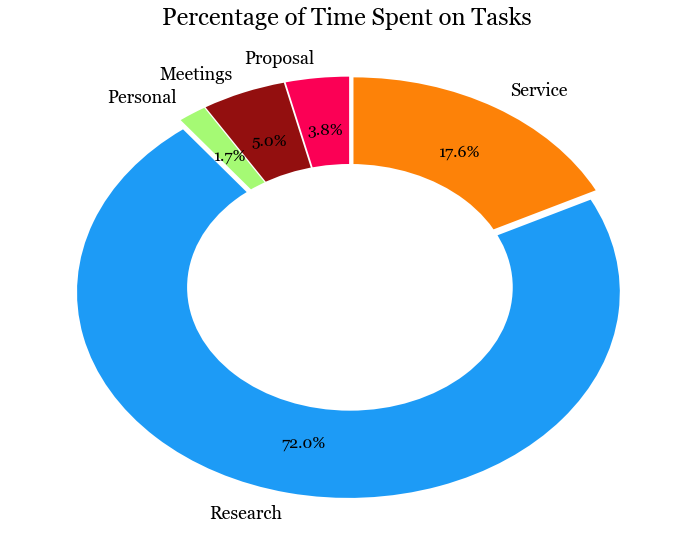

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  

mpl.rcParams['font.size'] = 16.0
mpl.rcParams['font.family'] = 'Georgia'

# Pie chart
labels = df.name.values
sizes = df.total_time.values / sum(df.total_time.values)
#colors
colors = df.color.values
#explsion
explode = [.025] * len(labels)
#explode = 1/sizes*0.002

plt.figure(figsize=(10,8))
patches, texts, autotexts = plt.pie(sizes, colors = colors, 
                                   labels = labels, 
                                   autopct = '%1.1f%%', 
                                   startangle = 90, 
                                   pctdistance = 0.75, 
                                   explode = explode)
for t in texts:
    t.set_fontsize(18)
plt.title("Percentage of Time Spent on Tasks ", fontname="Georgia", fontsize=24)

#draw circle
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()